<a href="https://colab.research.google.com/github/lg960214/DACON_Seoul_6/blob/feat%2Flhg/Ihk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#테스트

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.8 MB/s 
     |████████████████████████████████| 16.7 MB 45.7 MB/s 
     |████████████████████████████████| 6.3 MB 39.9 MB/s 


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/집계구.shp'
plt.rcParams['figure.figsize'] = (20, 20)
seoul = gpd.read_file(dir_shp)

In [4]:
dir_subway_eld = '/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv'
df_sub1 = pd.read_csv(dir_subway_eld, encoding='cp949')
date = np.unique(df_sub1['일자'])[-1]
df_sub1 = df_sub1[df_sub1['일자']==date]
df_sub1_ride = df_sub1[df_sub1['구분']=='합계 : 승차']
df_sub1_off = df_sub1[df_sub1['구분']=='합계 : 하차']
df_sub1_ride = df_sub1_ride.iloc[:, 3:].drop(columns=['구분'])

In [5]:
from shapely.geometry import Point
dir_subway_pos = '/content/drive/MyDrive/DACON6/지하철 시설 정보/서울시 역사마스터 정보.csv'
df_sub2 = pd.read_csv(dir_subway_pos, encoding='cp949')
df_sub2['역명'] = df_sub2['역사명']
df_sub2 = df_sub2.drop(columns=['역사명', '호선', '역사_ID'])

In [6]:
df_sub_off = pd.merge(df_sub1_off, df_sub2, on='역명')
df_sub_off = df_sub_off.groupby(by='역명').mean()
df_sub_off['역명'] = df_sub_off.index
df_sub_off.index = list(range(len(df_sub_off)))
s = gpd.GeoSeries([Point(x, y) for x, y in zip(df_sub_off['위도'], df_sub_off['경도'])])
geodf_off = gpd.GeoDataFrame(df_sub_off, geometry=s)
geodf_off.crs = 'epsg:4326'
geodf_off = geodf_off.to_crs(epsg=5179)
geodf_off = geodf_off.drop(columns=['연번', '역번호'])

In [7]:
df_sub_ride = pd.merge(df_sub1_ride, df_sub2, on='역명')
df_sub_ride = df_sub_ride.groupby(by='역명').mean()
df_sub_ride['역명'] = df_sub_ride.index
df_sub_ride.index = list(range(len(df_sub_ride)))
s = gpd.GeoSeries([Point(x, y) for x, y in zip(df_sub_ride['위도'], df_sub_ride['경도'])])
geodf_ride = gpd.GeoDataFrame(df_sub_ride, geometry=s)
geodf_ride.crs = 'epsg:4326'
geodf_ride = geodf_ride.to_crs(epsg=5179)

In [9]:
geodf_off.columns

Index(['06시이전', '06시-07시', '07시-08시', '08시-09시', '09시-10시', '10시-11시',
       '11시-12시', '12시-13시', '13시-14시', '14시-15시', '15시-16시', '16시-17시',
       '17시-18시', '18시-19시', '19시-20시', '20시-21시', '21시-22시', '22시-23시',
       '23시이후', '위도', '경도', '역명', 'geometry'],
      dtype='object')

In [10]:
from tqdm import tqdm

def MakeHeatMap(target):
  seoul['heat_'+target+'_ride'] = 0
  seoul['heat_'+target+'_off'] = 0
  heatlist_ride = []
  heatlist_off = []

  station_centroid = seoul.geometry.centroid

  def weight_func(x):
    return 10 ** (0.0005 * -x)

  for i in tqdm(range(len(seoul))):
    center = station_centroid[i]
    heat_ride = 0
    heat_off = 0

    for j in range(len(geodf_ride)):
      raw = geodf_ride.loc[j, target]
      pos = geodf_ride.geometry[j]
      d = raw * weight_func(((center.x-pos.x)**2+(center.y-pos.y)**2)**0.5)
      heat_ride += d
    heatlist_ride.append(heat_ride)

    for j in range(len(geodf_off)):
      raw = geodf_off.loc[j, target]
      pos = geodf_off.geometry[j]
      d = raw * weight_func(((center.x-pos.x)**2+(center.y-pos.y)**2)**0.5)
      heat_off += d
    heatlist_off.append(heat_off)

  seoul['heat_'+target+'_ride'] = heatlist_ride
  seoul['heat_'+target+'_off'] = heatlist_off

  fig, ax = plt.subplots()
  ax.axis('off')
  seoul.plot('heat_'+target+'_ride', ax=ax, legend=True)
  ax.set_title('heat_'+target+'_ride')
  #geodf.plot(geodf.columns[target_idx], ax=ax)
  fig.savefig('heat_'+target+'_ride')

  fig, ax = plt.subplots()
  ax.axis('off')
  seoul.plot('heat_'+target+'_off', ax=ax, legend=True)
  ax.set_title('heat_'+target+'_off')
  #geodf.plot(geodf.columns[target_idx], ax=ax)
  fig.savefig('heat_'+target+'_off.png')

100%|██████████| 19153/19153 [13:01<00:00, 24.52it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
100%|██████████| 19153/19153 [12:21<00:00, 25.82it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/ma

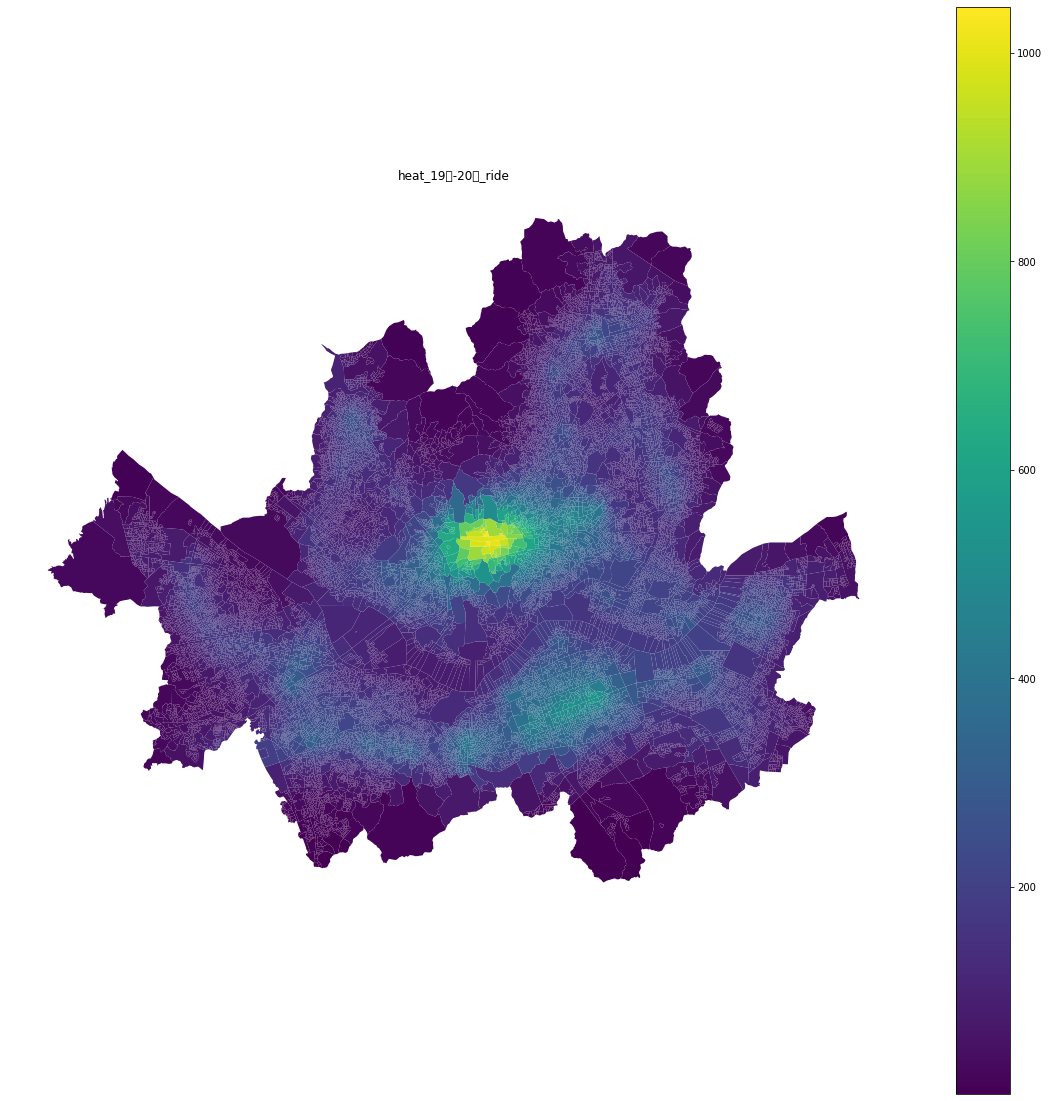

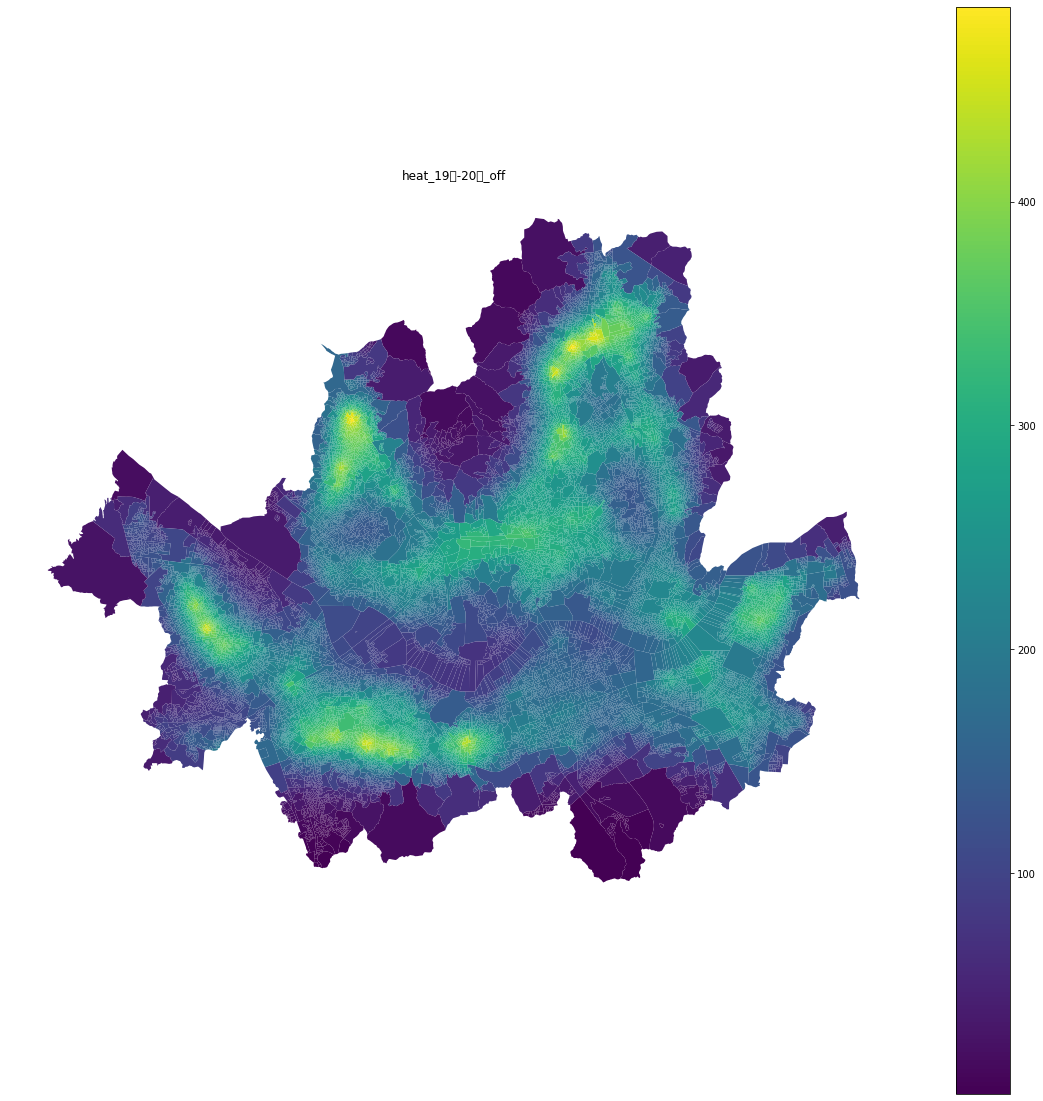

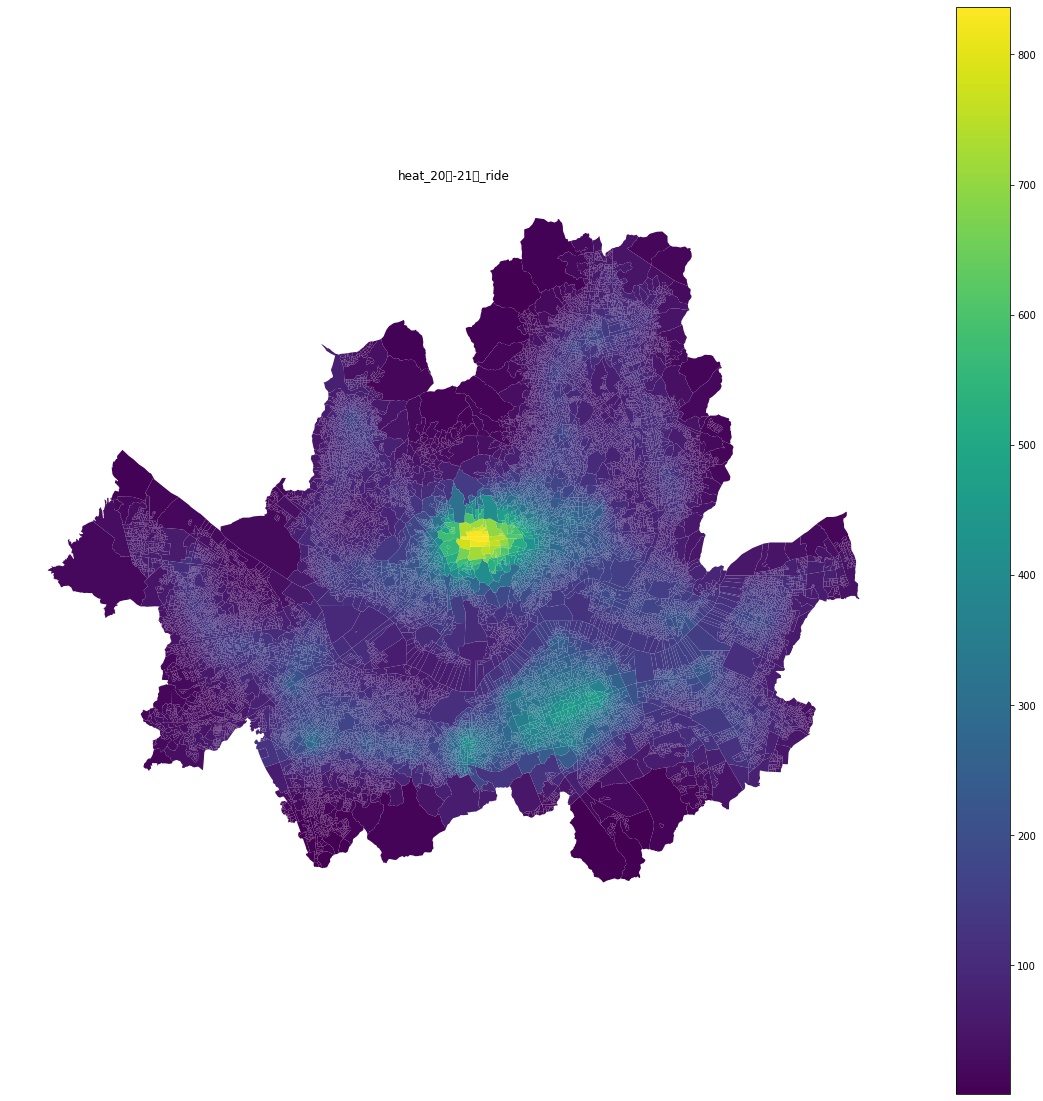

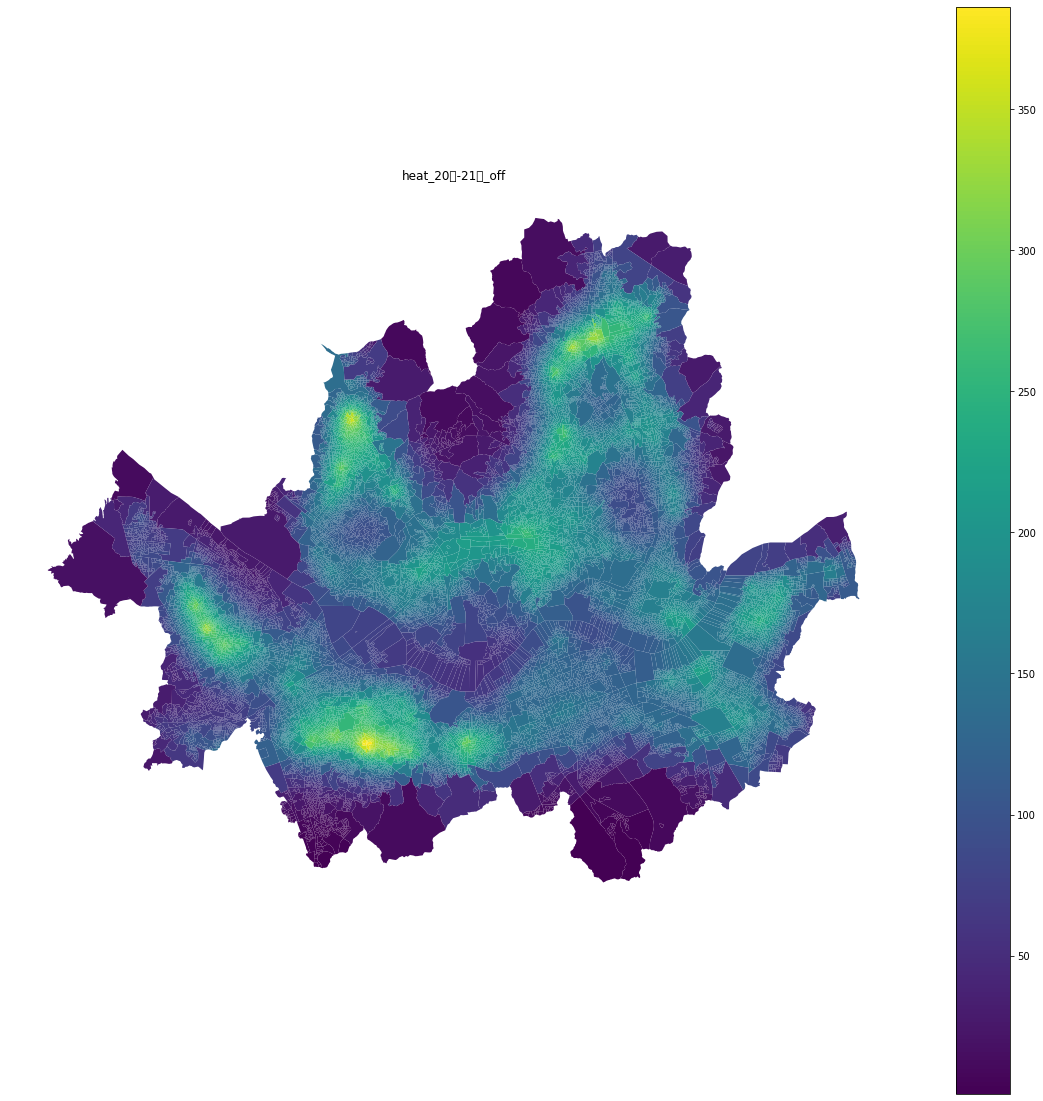

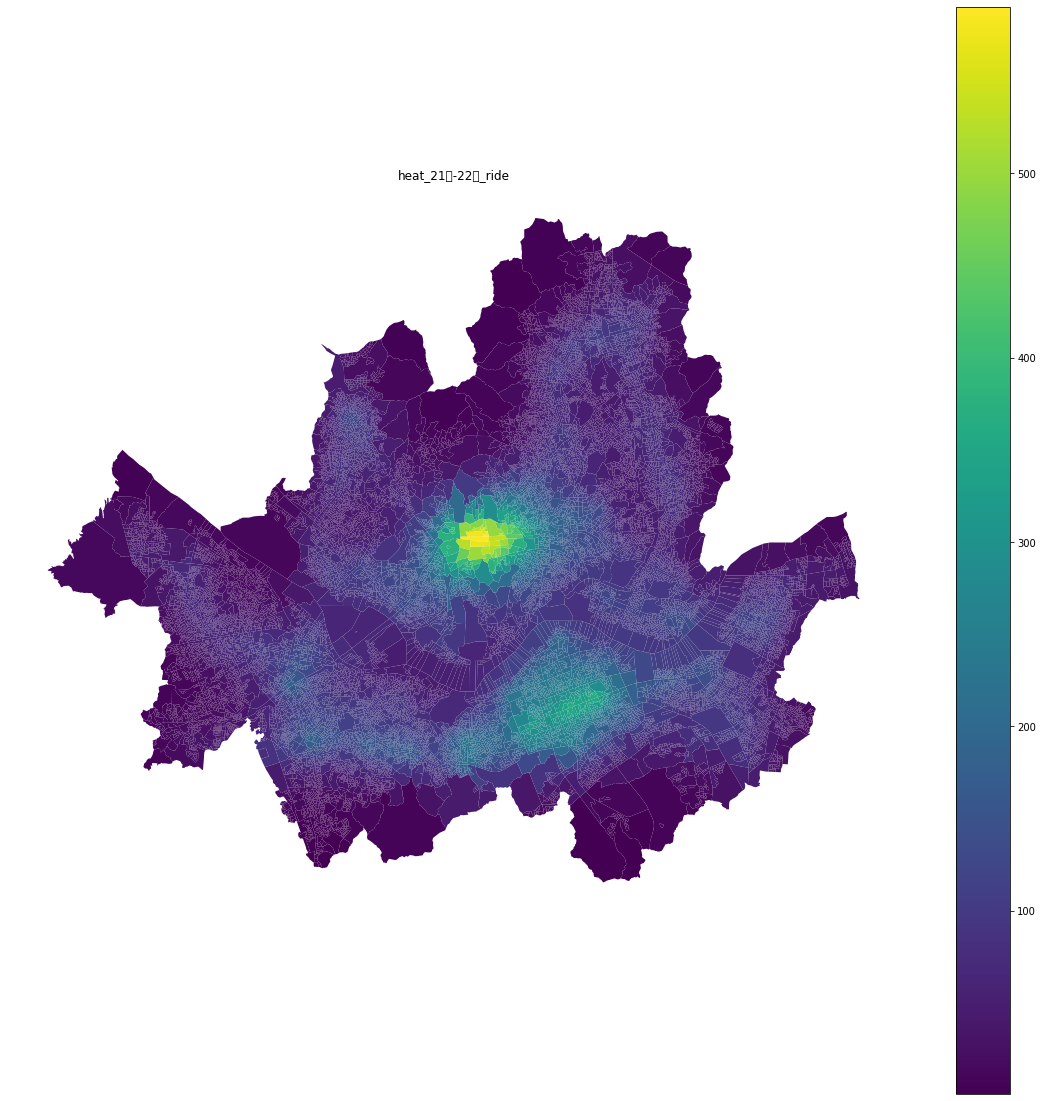

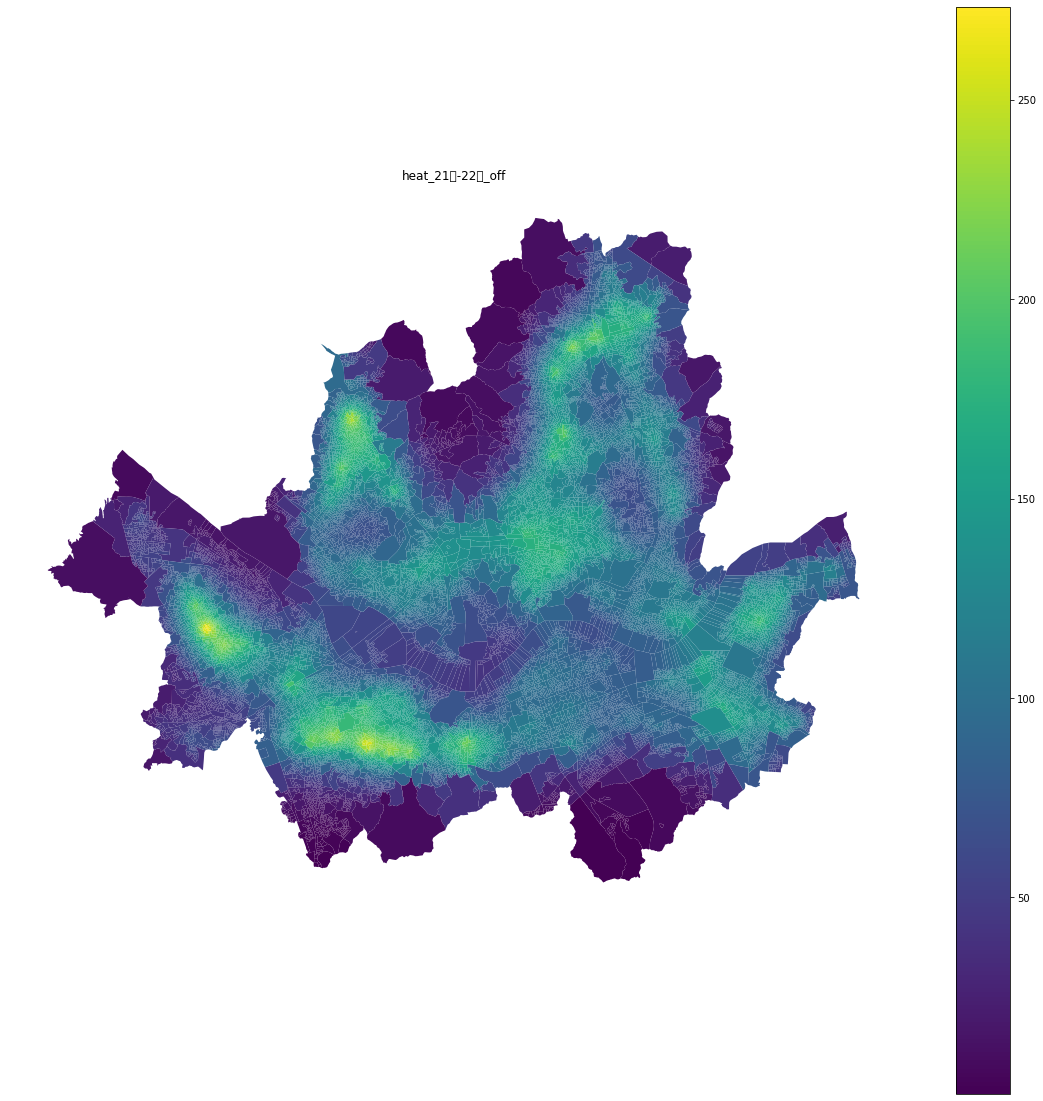

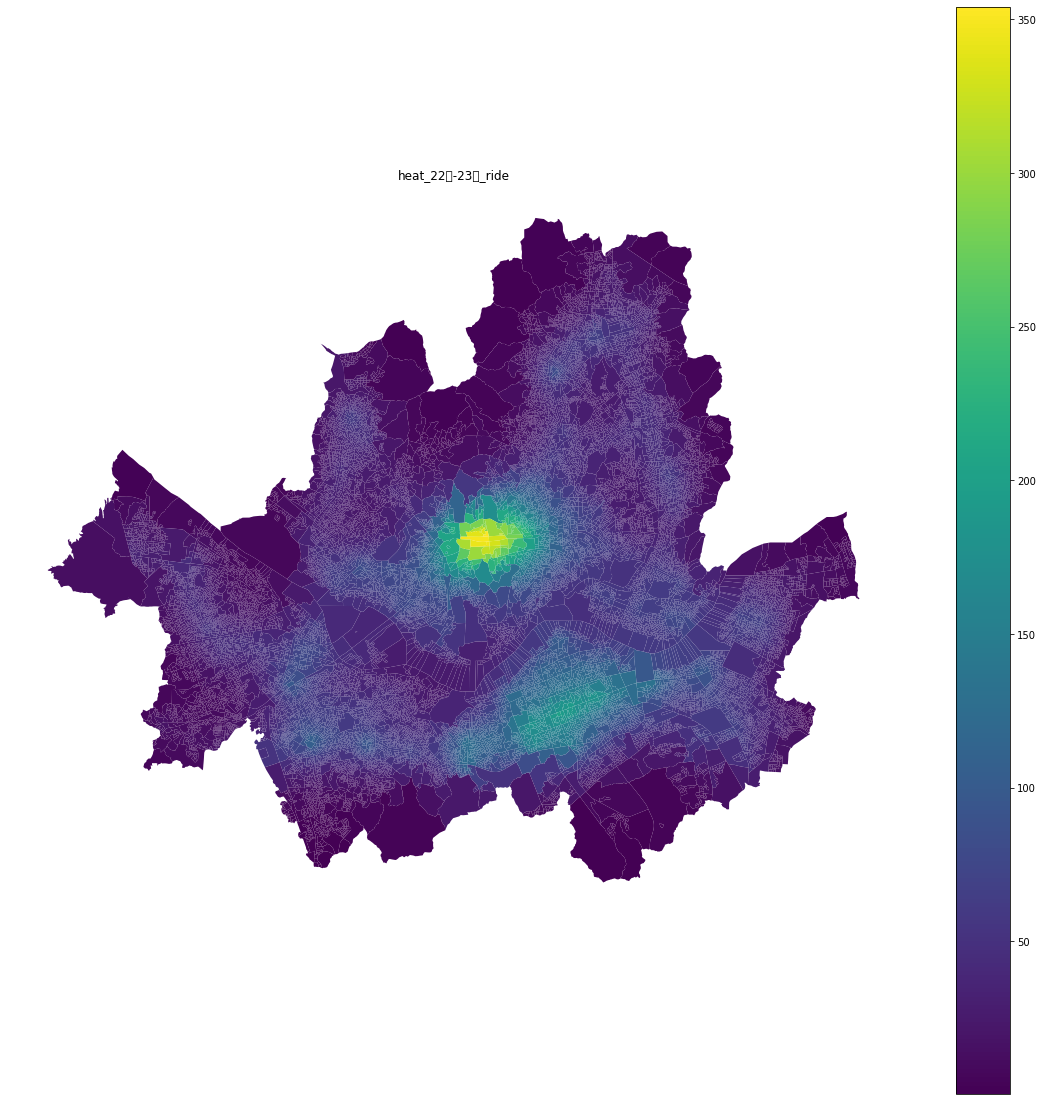

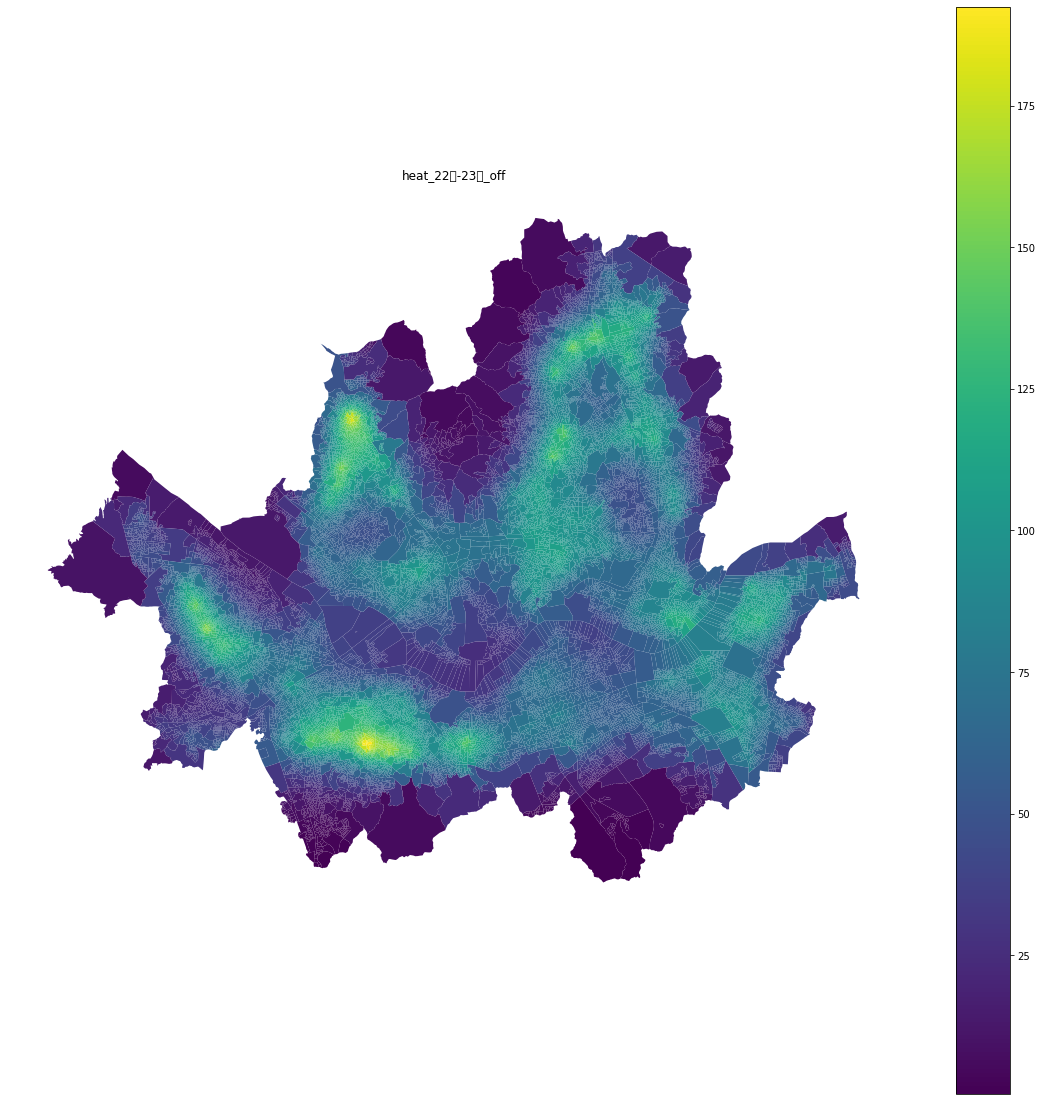

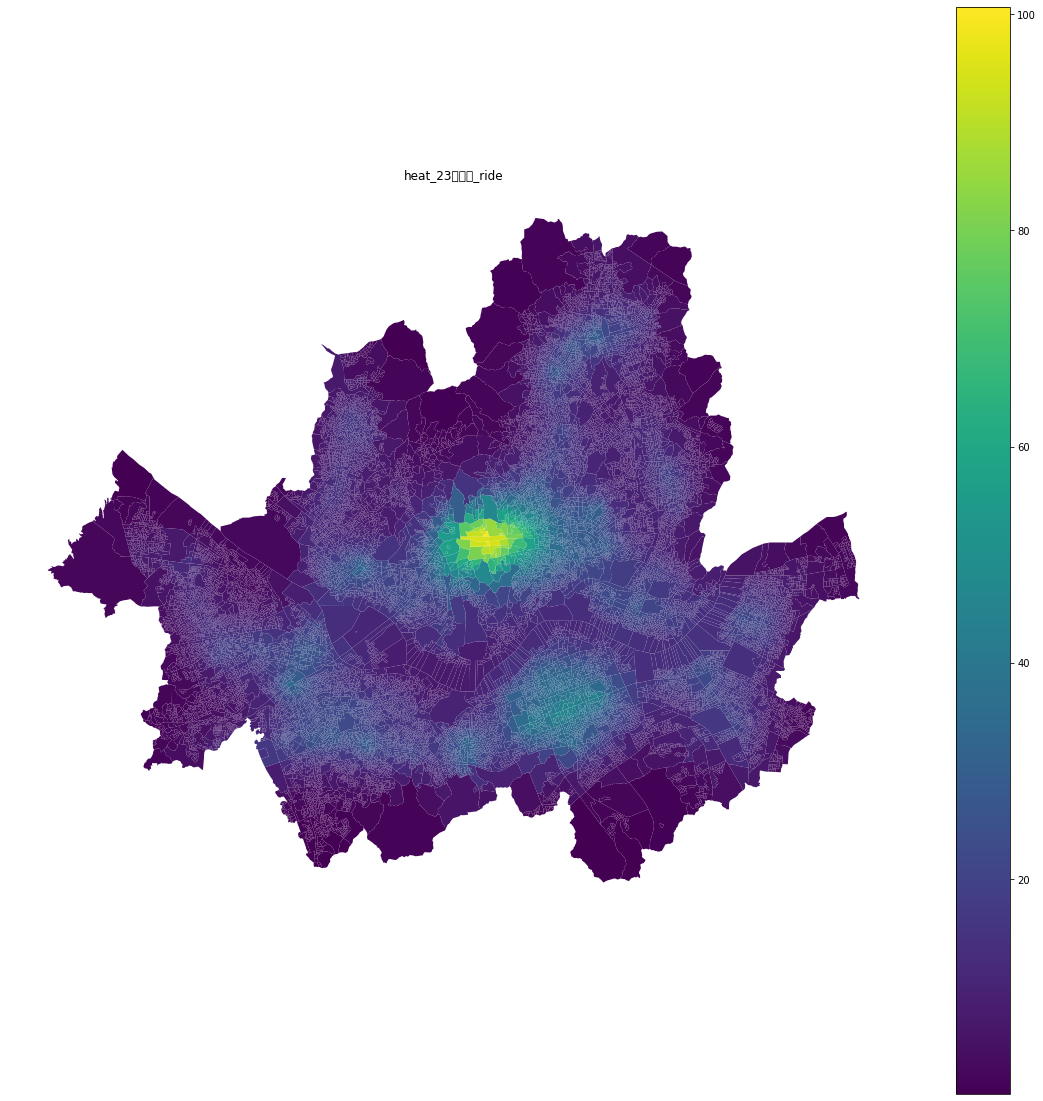

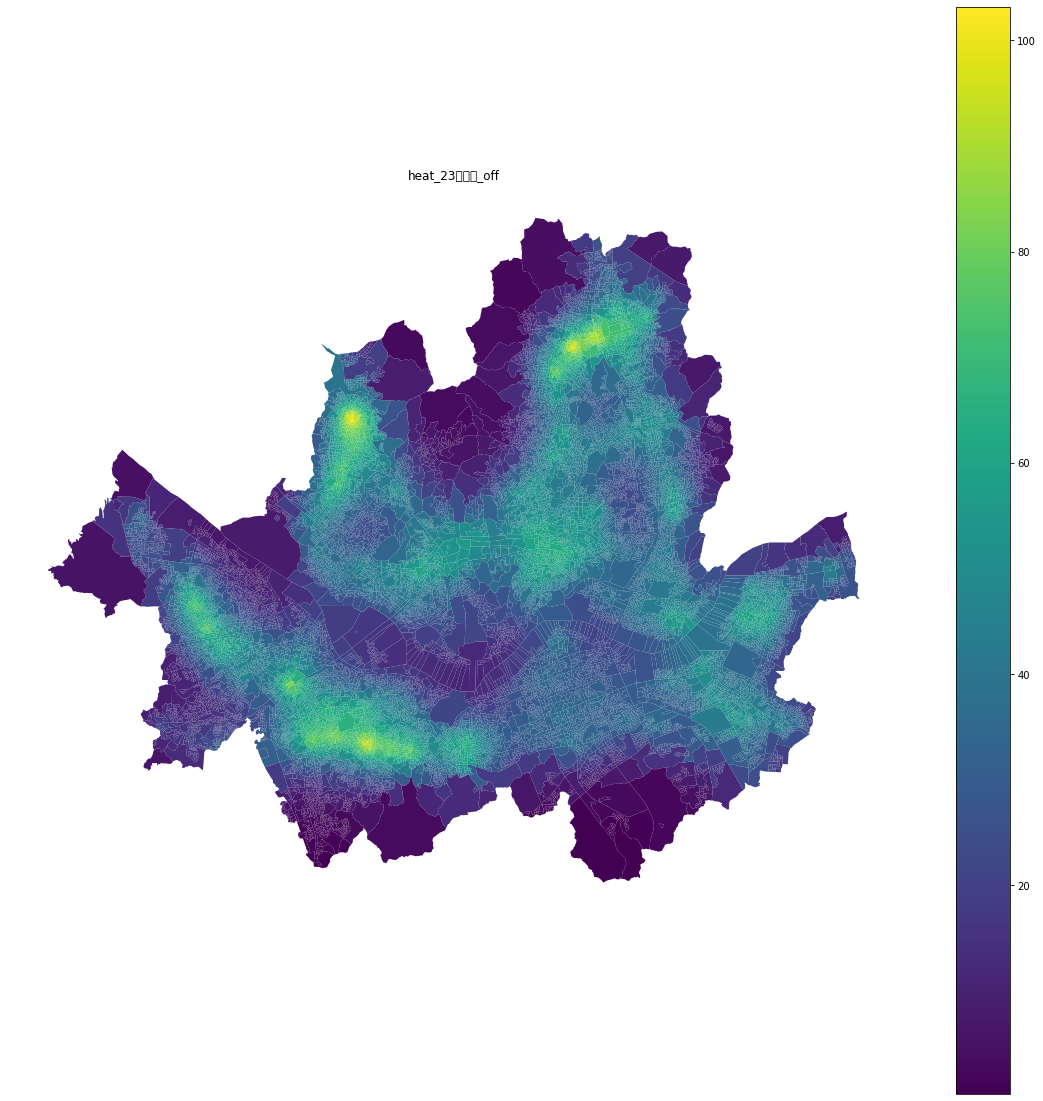

In [11]:
for c in geodf_off.columns[14:19]:
  MakeHeatMap(c)